### InstaCart Orders

-Analyzed a sample of over 3 million grocery orders from more than 200,000 Instacart anonymized users. For each user, 4 to 100 of their orders are given, with the basket of products purchased in each order

-The goal of my analysis was to help our marketing team understand what variables determine whether or not a customer will place a reorder of a product.   

-Assumptions: orders could be clustered into different groups.

-Data cleaning: Working ~32 million rows of data ran into memory issues. Taking 10% randomized sample of the data set which still allowed for a substantial amount of data to analyze but was more manageable to manipulate.

Also dropped rows with NaNs in days since reorder column in the reorder column because there was no data yet for the number of the days since they placed the order and it was less than 5% of the data. 



In [14]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics
color = sns.color_palette()

%matplotlib inline

In [2]:
aisles = pd.read_csv("data/aisles.csv")
departments = pd.read_csv("data/departments.csv")
order_prior = pd.read_csv("data/order_products__prior.csv")
order_train = pd.read_csv("data/order_products__train.csv")
order = pd.read_csv("data/orders.csv")
products = pd.read_csv("data/products.csv")



In [18]:
order_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [19]:
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [3]:
order_prior = pd.merge(order_prior, products, on='product_id', how='inner')
order_prior.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id
0,2,33120,1,1,Organic Egg Whites,86,16
1,26,33120,5,0,Organic Egg Whites,86,16
2,120,33120,13,0,Organic Egg Whites,86,16
3,327,33120,5,1,Organic Egg Whites,86,16
4,390,33120,28,1,Organic Egg Whites,86,16


In [4]:
order_prior = pd.merge(order_prior, order, on='order_id', how='inner')
order_prior.head()


,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2,33120,1,1,Organic Egg Whites,86,16,202279,prior,3,5,9,8.0
1,2,28985,2,1,Michigan Organic Kale,83,4,202279,prior,3,5,9,8.0
2,2,9327,3,0,Garlic Powder,104,13,202279,prior,3,5,9,8.0
3,2,45918,4,1,Coconut Butter,19,13,202279,prior,3,5,9,8.0
4,2,30035,5,0,Natural Sweetener,17,13,202279,prior,3,5,9,8.0


In [5]:
order_prior.shape

(32434489, 13)

In [6]:
order_prior.dtypes

order_id                    int64
product_id                  int64
add_to_cart_order           int64
reordered                   int64
product_name               object
aisle_id                    int64
department_id               int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

In [7]:
order_prior.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,32434489.0,1.710749e+06,987300.696453,2.0,855943.0,1711048.0,2565514.0,3421083.0
product_id,32434489.0,2.557634e+04,14096.689090,1.0,13530.0,25256.0,37935.0,49688.0
add_to_cart_order,32434489.0,8.351076e+00,7.126671,1.0,3.0,6.0,11.0,145.0
reordered,32434489.0,5.896975e-01,0.491889,0.0,0.0,1.0,1.0,1.0
aisle_id,32434489.0,7.121430e+01,38.203023,1.0,31.0,83.0,107.0,134.0
department_id,32434489.0,9.921906e+00,6.281156,1.0,4.0,9.0,16.0,21.0
user_id,32434489.0,1.029372e+05,59466.478268,1.0,51421.0,102611.0,154391.0,206209.0
order_number,32434489.0,1.714205e+01,17.535040,1.0,5.0,11.0,24.0,99.0
order_dow,32434489.0,2.738818e+00,2.090049,0.0,1.0,3.0,5.0,6.0
order_hour_of_day,32434489.0,1.342498e+01,4.246365,0.0,10.0,13.0,16.0,23.0


In [7]:
order_sample =  order_prior.sample(frac = .1, random_state=34)


In [15]:
order_sample.shape

(3243449, 13)

In [16]:
order_sample.isnull().sum()

order_id                       0
product_id                     0
add_to_cart_order              0
reordered                      0
product_name                   0
aisle_id                       0
department_id                  0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    207721
dtype: int64

In [10]:
order_sample.dropna(axis=0, how = 'any', inplace = True)

In [8]:
order_sample.head().T


,18540574,14269592,19926412,12048287,3776836
order_id,1964745,2150216,3397428,1582554,109782
product_id,27086,46906,24852,19348,3599
add_to_cart_order,4,3,1,2,7
reordered,1,1,1,1,1
product_name,Half & Half,Grape White/Green Seedless,Banana,Fat Free Milk,Baked Aged White Cheddar Rice and Corn Puffs
aisle_id,53,24,24,84,23
department_id,16,4,4,16,19
user_id,108871,26785,173529,17677,45382
eval_set,prior,prior,prior,prior,prior
order_number,28,15,8,65,19


In [22]:
X = order_sample.drop(['order_id','product_id','user_id','product_name','eval_set','aisle_id','department_id'], axis=1)
#X = order_sample.drop(['add_to_cart_order','order_number','days_since_prior_order','order_hour_of_day','order_dow','order_id','user_id','product_name','eval_set','aisle_id','department_id'], axis=1)
from sklearn.cluster import KMeans
km = KMeans(n_clusters=5, random_state=34)
km.fit(X)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=34, tol=0.0001, verbose=0)

In [37]:
km.labels_

array([3, 0, 0, ..., 3, 3, 0], dtype=int32)

In [23]:
order_sample['cluster'] = km.labels_
order_sample.sort_values('cluster')

,order_id,product_id,add_to_cart_order,reordered,product_name,aisle_id,department_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,cluster
6974966,2784497,16131,20,0,"Organic Chicken Noodle Soup, Reduced Sodium",69,15,146362,prior,18,1,14,13.0,0
8028520,3125219,26604,24,0,Organic Blackberries,24,4,73973,prior,2,0,7,25.0,0
13957928,1268183,40332,23,0,"Cage Free Brown Eggs-Large, Grade A",86,16,14213,prior,6,3,12,10.0,0
8144137,26773,895,22,1,YoKids Squeeze Organic Blueberry Blue Yogurt,120,16,193390,prior,8,1,10,10.0,0
16380634,499013,36390,13,0,Grilled Chicken Alfredo Bake Frozen Dinner,38,1,125886,prior,20,1,13,10.0,0
11407118,3247824,22950,28,0,Natural Free & Clear Dishwasher Detergent Packs,74,17,123399,prior,5,1,18,15.0,0
15138795,2541205,8174,27,1,Organic Navel Orange,24,4,91987,prior,18,6,11,3.0,0
22563889,1810543,7644,17,0,Scoops! Tortilla Chips,107,19,167685,prior,18,3,15,2.0,0
12772978,1755645,47626,15,1,Large Lemon,24,4,164265,prior,5,4,11,15.0,0
2169373,2311605,8424,35,1,Broccoli Crown,83,4,28630,prior,27,6,12,27.0,0


In [24]:
km.cluster_centers_

array([[21.4518676 ,  0.47773203, 11.44168041,  2.71132274, 13.27521046,
        10.46402797],
       [ 7.5271796 ,  0.50595426,  7.46144391,  2.67537945, 13.57052228,
        26.53447186],
       [ 8.04458153,  0.82965926, 64.90166305,  2.82735448, 13.04418836,
         4.54614064],
       [ 5.65411269,  0.6080025 ,  9.20981939,  2.74811432, 13.54545059,
         7.63580908],
       [ 7.63326114,  0.78657408, 32.07402859,  2.76901471, 13.21621529,
         6.91474395]])

In [25]:
centers_kmeans = order_sample.groupby('cluster').mean()

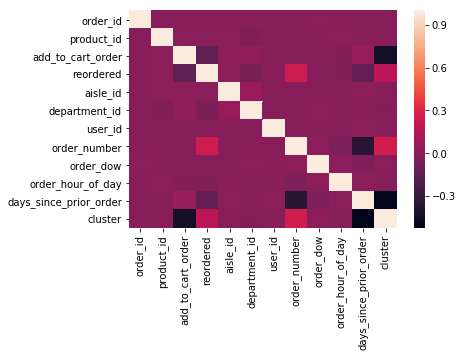

In [81]:
sns.heatmap(order_sample.corr())

In [80]:
feature_cols = ['days_since_prior_order','add_to_cart_order','order_number']

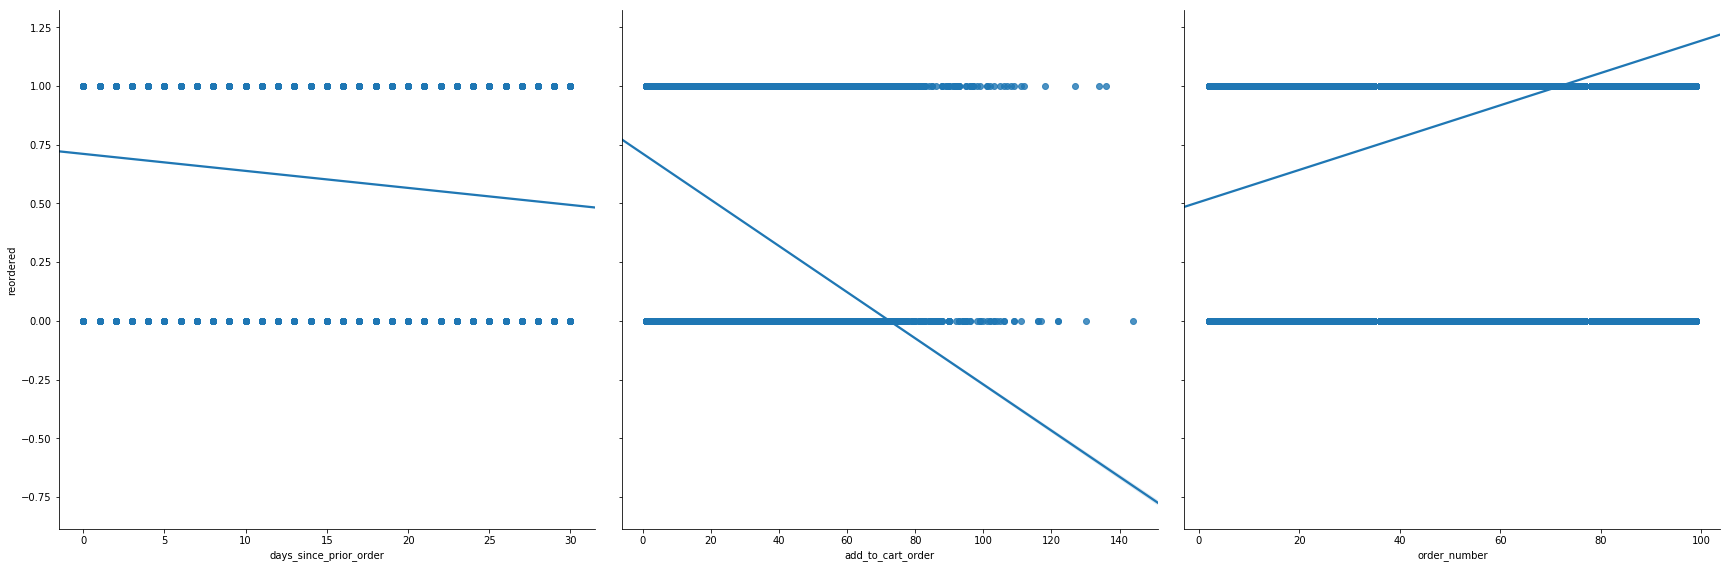

In [83]:
sns.pairplot(order_sample, x_vars=feature_cols, y_vars='reordered', kind='reg',height=8, aspect=1);

In [38]:
from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
order_sample.dropna(axis=0)
X = order_sample[['days_since_prior_order','add_to_cart_order','order_number']]
y = order_sample.reordered

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)

LR.fit(X_train,y_train)

model = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

/Users/cyt.mead/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cyt.mead/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [12]:
#Features = 'days_since_prior_order','add_to_cart_order','order_number'

y_pred = LR.predict(X_test)

LR.score(X_test, y_test)

0.673609756868863

In [39]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.5713057352513948


In [16]:
y_train.mean()

0.6301614198197818

In [40]:

from sklearn.linear_model import LogisticRegression
LR = LogisticRegression()
order_sample.dropna(axis=0)
X = order_sample[['cluster','days_since_prior_order','add_to_cart_order','order_number']]
y = order_sample.reordered

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)

LR.fit(X_train,y_train)

model = LR.fit(X_train, y_train)
y_pred = LR.predict(X_test)

/Users/cyt.mead/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/cyt.mead/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [41]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.5740012859244575


In [42]:
#model performance with k-means clusters + 'days_since_prior_order','add_to_cart_order','order_number'

y_pred = LR.predict(X_test)

LR.score(X_test, y_test)


0.674940574386111

In [36]:
X = order_sample[['days_since_prior_order','add_to_cart_order','order_number']]
y = order_sample.reordered
from sklearn.tree import DecisionTreeClassifier
dec_tree = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)
dec_tree = DecisionTreeClassifier(min_samples_split=3)
dec_tree.fit(X_train, y_train)

model = dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)

In [47]:
dec_tree.score(X_test, y_test)

0.6905467156477787

In [37]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.5562591987984425


In [33]:
X = order_sample[['cluster','days_since_prior_order','add_to_cart_order','order_number']]
y = order_sample.reordered
dec_tree = DecisionTreeClassifier()
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)
dec_tree = DecisionTreeClassifier(min_samples_split=3)
dec_tree.fit(X_train, y_train)

model = dec_tree.fit(X_train, y_train)
y_pred = dec_tree.predict(X_test)

In [34]:
dec_tree.score(X_test, y_test)

0.690434716153753

In [35]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.556385912695718


In [71]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = order_sample[['days_since_prior_order','add_to_cart_order','order_number', 'cluster']]
y = order_sample.reordered
knn = KNeighborsClassifier(n_neighbors=103)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=103, p=2,
                     weights='uniform')

In [73]:
#k=103
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

#0.6742330011120891

0.6950925774641207


In [42]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

X = order_sample[['days_since_prior_order','add_to_cart_order','order_number']]
y = order_sample.reordered
knn = KNeighborsClassifier(n_neighbors=125)

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 34)

knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

In [75]:
y_pred_class = knn.predict(X_test)
print((metrics.accuracy_score(y_test, y_pred_class)))

#k=17
0.6826975275782283
#k=19
0.6834973357296833
#k=21
0.6853380803550252
#k=23
0.6864514870897525
#k=25
0.6872960950388177
#k=31
0.68974822513743
#k=37
0.690973631366183
#k=41
0.6913241239004285
#k=45
0.6922227551348474
#k=53
0.6934283967470076
#k=71
0.6940147470392605
#k=103
0.6951189302862444
#k=113
0.6955563871334981
#k=125
0.6961335139380076

0.6951189302862444

In [43]:
print(np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

0.5512408602979213


Conclusion: 69.6% of the variation in re-orders can be explained by the number of days since the prior order, the order in which the product was added to a cart, and which order number this is for the customer. For next steps, I would make the KNN model avaible to the marketing team via a GUI as it performed the best while having the lowest error so they can build better targeted marketing campaigns to rengage customers who are currently unlikely to place a reorder based on these features. 